# Toxic Comment Classification

This notebook explores a few deep learning methods to detect different types of toxicity like threats, obscenity, insults, and identity-based hate in online comments. The models are trained and tested on a dataset of comments from Wikipedia's talk page edits.

This is a recently concluded Kaggle competition. More details can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).

### Models Explored:

Since the focus is on deep learning, the baseline model is a nerual net with one hidden layer with 128 units that takes as input a count vector based on a vocabulary size of 15000. The models explored thereafter are:
1. A neural net that learns an embedding layer
2. A neural net that uses transfer learning by using the GloVe model for initialization of weights of embedding layer
3. A recurrent neural net that uses the GloVe model as above

In [3]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import math
import _pickle as pkl

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.metrics import roc_auc_score, confusion_matrix

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM, Dropout
from keras.callbacks import EarlyStopping, Callback
from keras.models import load_model

from matplotlib import pyplot as plt

### Data Loading and Analysis

In [4]:
# set seed for reproducibility
seed = 9
np.random.seed(seed)

# load the training data
data = pd.read_csv("data/train.csv")

# check a sample of the training data
print (data.sample(5))

                      id                                       comment_text  \
132098  c2e4984fc60bdcf5  right i cant email you for some weird reason i...   
34027   5ac9bd5e6591d3a0  I don't quite get edit summary. Can you please...   
37124   6318b61ce38def8a  Battleground spirit ; removal of source materi...   
80033   d620e563f3ada671  "\n\nTalk Page Message\nNo, I was removing Dre...   
152635  904973fde1b8394c  If you visited Middlesbrough especially the ri...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
132098      0             0        0       0       0              0  
34027       0             0        0       0       0              0  
37124       0             0        0       0       0              0  
80033       0             0        0       0       0              0  
152635      0             0        0       0       0              0  


In [3]:
# check if there are any null values in the training data
print (data.isnull().any())

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool


In [5]:
dependent_vars = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

data['sum_dvs'] = data[dependent_vars].sum(axis=1)
# print number of data points that have more than one label
print (data.loc[data['sum_dvs'] > 1].shape)

(9865, 9)


Since, there are 9865 rows with data['sum_dvs'] > 1, we need to treat this problem as a binary classification for all 6 of the labels. i.e. each comment can have more than 1 label - a multi-label mlti-class problem. Hence, we'll be using binary_crossentropy as loss function for the optimizer and a sigmoid activation function(instead of softmax) for the output layer. 

There are many spelling errors that can be corrected depending on the models used.

In [76]:
def display_label_distribution(data):
    # find data points that have atleast one label
    print ('total:', data.loc[data['sum_dvs'] > 0].shape)

    # find how the labels are distributed
    for var in dependent_vars:
        print (var + ': ' + str(data.loc[data[var] == 1].shape))

display_label_distribution(data)

total: (16225, 9)
toxic: (15294, 9)
severe_toxic: (1595, 9)
obscene: (8449, 9)
threat: (478, 9)
insult: (7877, 9)
identity_hate: (1405, 9)


The results above indicate that there is a label imbalance in the dataset.

### Data Preprocessing

In [28]:
# choose a vocabulary size
max_features = 15000

# choose a validation and test split
validation_split = 0.1
test_split = 0.2

#shuffle the dataset
data = data.reindex(np.random.permutation(data.index))


In [29]:
# clean the comments by removing stopwords
def clean_comment_text(comment):
    stop_words = text.ENGLISH_STOP_WORDS
    word_list = []
    for word in comment.lower().split():
        word = word.replace('!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789', '')
        if (word not in stop_words and len(word) > 1):
            word_list.append(word)
    cleaned_comment = ' '.join(word_list)
    return cleaned_comment

data['comment_text'] = data['comment_text'].apply(clean_comment_text)
data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_dvs
35418,5e983bd8ba291ed5,"took care one. pinged park, feeding duckies; s...",0,0,0,0,0,0,0
9382,18e505d8aa1fcab0,wrong fag,1,0,0,0,0,0,1
2959,07ff0744ebbf7c82,"want ongoing, respond comments made. said newb...",0,0,0,0,0,0,0
41095,6da6f59a4cc1a4fb,"knowledge, wikipedia does policy newspaper art...",0,0,0,0,0,0,0
41604,6ef66dd18cb089d3,"none. massive abuse blocking system, huge over...",0,0,0,0,0,0,0


In [77]:
def split_df(data, split):
    size = data.shape[0]
    test_size = math.ceil(size * split)

    train = data.head(size - test_size)
    test = data.tail(test_size)
    return train, test

# split the data into training, test, and validation sets
train, test = split_df(data, test_split)
train, validation = split_df(train, validation_split)

y_train = train[dependent_vars].values
y_validation = validation[dependent_vars].values
y_test = test[dependent_vars].values

# make sure that all datasets have all the labels
print ("TRAIN")
display_label_distribution(train)
print ("\nVALIDATION")
display_label_distribution(validation)
print ("\nTEST")
display_label_distribution(test)

TRAIN
total: (11614, 9)
toxic: (10947, 9)
severe_toxic: (1131, 9)
obscene: (6063, 9)
threat: (346, 9)
insult: (5612, 9)
identity_hate: (1027, 9)

VALIDATION
total: (1309, 9)
toxic: (1230, 9)
severe_toxic: (104, 9)
obscene: (679, 9)
threat: (40, 9)
insult: (658, 9)
identity_hate: (109, 9)

TEST
total: (3302, 9)
toxic: (3117, 9)
severe_toxic: (360, 9)
obscene: (1707, 9)
threat: (92, 9)
insult: (1607, 9)
identity_hate: (269, 9)


In [78]:
# Fit a Tokenizer on only the train data. The vocabulary (max_features) we need to learn should be based only on the 
# training data. This is so that we can emulate the validation loss as close as possible to that of the test data 
# where there could be words that we haven't encountered before.
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789')
tokenizer.fit_on_texts(list(train['comment_text']))

In [9]:
print ("Number of unique words: ", len(tokenizer.word_index))

# check if the selected vocabulary is reliable
count = 0
for i, word in tokenizer.word_index.items():
    count += 1
    print (i, word)
    if count > 20000:
        break
    if count % 10000 == 0:
        print ("########################################################################################################")

Number of unique words:  170455
article 1
page 2
wikipedia 3
talk 4
like 5
just 6
don't 7
it 8
think 9
know 10
edit 11
you 12
i'm 13
people 14
it's 15
articles 16
use 17
time 18
did 19
user 20
thanks 21
make 22
good 23
information 24
does 25
want 26
deletion 27
sources 28
way 29
wp 30
help 31
pages 32
image 33
new 34
me 35
source 36
editing 37
section 38
fuck 39
need 40
say 41
edits 42
thank 43
here 44
this 45
deleted 46
used 47
really 48
discussion 49
work 50
i've 51
point 52
right 53
add 54
read 55
hi 56
look 57
that 58
fact 59
you're 60
list 61
link 62
said 63
wiki 64
going 65
i 66
stop 67
content 68
blocked 69
block 70
history 71
http 72
added 73
utc 74
editors 75
removed 76
note 77
the 78
welcome 79
free 80
place 81
sure 82
case 83
reason 84
vandalism 85
again 86
and 87
doesn't 88
better 89
comment 90
that's 91
personal 92
actually 93
ask 94
feel 95
using 96
question 97
best 98
links 99
person 100
believe 101
things 102
is 103
so 104
comments 105
policy 106
hope 107
well 108
can't

missing 964
cock 965
reader 966
easy 967
basis 968
study 969
fun 970
september 971
easily 972
middle 973
noted 974
solid 975
wikipedians 976
rr 977
social 978
month 979
other 980
have 981
controversial 982
expect 983
college 984
definitely 985
sounds 986
introduction 987
russian 988
reasonable 989
indian 990
rfc 991
moment 992
tacos 993
accounts 994
movie 995
n 996
nomination 997
speedily 998
lies 999
explained 1000
meets 1001
guide 1002
strong 1003
effect 1004
categories 1005
vandal 1006
shut 1007
total 1008
protected 1009
david 1010
propaganda 1011
basic 1012
nazi 1013
february 1014
movement 1015
seeing 1016
money 1017
hear 1018
itself 1019
local 1020
required 1021
unsourced 1022
difficult 1023
suggestion 1024
referenced 1025
european 1026
ideas 1027
board 1028
effort 1029
season 1030
hitler 1031
chinese 1032
racist 1033
merge 1034
eat 1035
episode 1036
btw 1037
wonder 1038
quick 1039
west 1040
discussing 1041
speaking 1042
ignore 1043
down 1044
suggested 1045
enough 1046
guideline 1

worry 1714
civility 1715
confusing 1716
complaint 1717
writer 1718
met 1719
israeli 1720
verified 1721
male 1722
songs 1723
iran 1724
assad 1725
worst 1726
preceding 1727
anyone 1728
arab 1729
—preceding 1730
expand 1731
perspective 1732
smart 1733
https 1734
defend 1735
talkpage 1736
dickhead 1737
department 1738
wishes 1739
versions 1740
compromise 1741
method 1742
sexual 1743
track 1744
pop 1745
natural 1746
station 1747
bob 1748
sides 1749
brief 1750
censorship 1751
plenty 1752
violate 1753
intention 1754
propose 1755
turned 1756
forces 1757
ground 1758
signature 1759
spent 1760
italian 1761
disputes 1762
your 1763
pussy 1764
restore 1765
federal 1766
they 1767
excellent 1768
dictionary 1769
nations 1770
strange 1771
insult 1772
zero 1773
goal 1774
begin 1775
delay 1776
liberal 1777
repeated 1778
intro 1779
specified 1780
scholars 1781
pre 1782
calls 1783
heil 1784
determine 1785
reads 1786
signed 1787
build 1788
episodes 1789
length 1790
wing 1791
belief 1792
ya 1793
archives 1794

chosen 2463
successful 2464
consideration 2465
desire 2466
punk 2467
mamas 2468
specifies 2469
ugly 2470
historian 2471
girls 2472
greatest 2473
republican 2474
master 2475
watchlist 2476
may 2477
idiots 2478
fox 2479
serbia 2480
christmas 2481
ie 2482
tommy 2483
caught 2484
creator 2485
violence 2486
fyi 2487
annoying 2488
historic 2489
buy 2490
rollback 2491
print 2492
occupation 2493
liar 2494
anthony 2495
newspapers 2496
marked 2497
arabic 2498
texas 2499
bringing 2500
mistaken 2501
director 2502
handle 2503
pain 2504
unconstructive 2505
administration 2506
commented 2507
causes 2508
viewpoint 2509
limit 2510
pointless 2511
medicine 2512
machine 2513
notices 2514
everyone 2515
defense 2516
conditions 2517
origins 2518
market 2519
promoting 2520
unit 2521
vast 2522
respected 2523
methods 2524
upset 2525
experts 2526
artists 2527
teams 2528
bum 2529
tony 2530
aspect 2531
innocent 2532
offended 2533
mike 2534
mission 2535
tips 2536
everything 2537
fac 2538
organisation 2539
croatian 2

growing 3212
partisan 3213
obtained 3214
baseball 3215
multi 3216
suit 3217
serbs 3218
weasel 3219
initially 3220
host 3221
miles 3222
applicable 3223
contested 3224
enemy 3225
yahoo 3226
figured 3227
spot 3228
those 3229
should 3230
editor's 3231
mode 3232
replacement 3233
rise 3234
jackson 3235
dated 3236
dab 3237
judgment 3238
towns 3239
encouraged 3240
semitic 3241
henry 3242
fields 3243
bits 3244
derived 3245
along 3246
dropped 3247
bully 3248
guidance 3249
meaningless 3250
disgusting 3251
warrant 3252
goals 3253
sell 3254
representation 3255
decades 3256
apologise 3257
updating 3258
picked 3259
serious 3260
ukraine 3261
threatened 3262
historically 3263
grade 3264
tiny 3265
accident 3266
kinda 3267
rename 3268
somewhere 3269
lake 3270
economy 3271
comics 3272
receiving 3273
remind 3274
fred 3275
someone 3276
assertions 3277
carried 3278
dozen 3279
header 3280
occur 3281
anime 3282
edu 3283
hist 3284
valley 3285
douche 3286
vandalise 3287
moral 3288
comprehensive 3289
assist 3290


birthday 3961
aidsaids 3962
superior 3963
privileges 3964
clinton 3965
reveal 3966
humor 3967
formula 3968
sep 3969
unfortunate 3970
fucked 3971
misinformation 3972
erased 3973
comparing 3974
narrative 3975
solved 3976
sight 3977
imho 3978
theme 3979
archiving 3980
opera 3981
sets 3982
angeles 3983
ideal 3984
begins 3985
louis 3986
sarah 3987
situations 3988
command 3989
pissed 3990
punishment 3991
etymology 3992
resulted 3993
symbols 3994
invalid 3995
sometimes 3996
martial 3997
countless 3998
screw 3999
universities 4000
alumni 4001
exceptions 4002
pride 4003
op 4004
questioned 4005
roy 4006
viewpoints 4007
incredibly 4008
aid 4009
affiliated 4010
serb 4011
zionist 4012
else's 4013
root 4014
linguistic 4015
undid 4016
anger 4017
roots 4018
reform 4019
distribution 4020
nicely 4021
taste 4022
corps 4023
abc 4024
rose 4025
johnson 4026
convert 4027
interaction 4028
ethics 4029
jay 4030
assumptions 4031
rating 4032
achieved 4033
vista 4034
lesson 4035
containing 4036
signs 4037
churches

winter 4632
successfully 4633
slight 4634
harvard 4635
kelly 4636
hong 4637
activist 4638
mother's 4639
joint 4640
kurdish 4641
upon 4642
wrongly 4643
contradict 4644
hurricane 4645
rangers 4646
counted 4647
schedule 4648
mormon 4649
£ 4650
labour 4651
cheap 4652
genuinely 4653
saving 4654
beach 4655
obtain 4656
biological 4657
catholics 4658
attract 4659
romania 4660
slaves 4661
ing 4662
musicians 4663
sing 4664
ac 4665
hahaha 4666
hypocritical 4667
relates 4668
socialism 4669
amusing 4670
criticized 4671
fighter 4672
headed 4673
wikinews 4674
mod 4675
beer 4676
christopher 4677
annual 4678
defeat 4679
dismissed 4680
refusing 4681
discouraged 4682
permissions 4683
virtual 4684
sysop 4685
hiv 4686
disrupt 4687
parent 4688
concluded 4689
baseless 4690
principal 4691
examine 4692
prophet 4693
coincidence 4694
dropping 4695
maintaining 4696
confidence 4697
searched 4698
queries 4699
demonstrates 4700
arm 4701
subst 4702
afc 4703
meetup 4704
confirms 4705
cheatsheet 4706
discredit 4707
lif

husband 5710
theorem 5711
pirates 5712
horses 5713
quo 5714
graph 5715
brackets 5716
respectable 5717
grave 5718
execution 5719
continuously 5720
favourite 5721
wikibreak 5722
refusal 5723
operated 5724
considerably 5725
portugal 5726
warranted 5727
enigmaman 5728
listas 5729
verse 5730
mosque 5731
basement 5732
purple 5733
unencyclopedic 5734
poetry 5735
testimony 5736
encouraging 5737
tail 5738
everyone's 5739
il 5740
brazilian 5741
berlin 5742
captions 5743
attitudes 5744
apologized 5745
aforementioned 5746
cinema 5747
vehicles 5748
judges 5749
debut 5750
males 5751
—the 5752
ab 5753
disrupting 5754
parameters 5755
conflicting 5756
inferior 5757
aryan 5758
poverty 5759
ideological 5760
ultra 5761
lebanese 5762
irrational 5763
oversight 5764
radiation 5765
parks 5766
otrs 5767
investment 5768
linguistics 5769
mount 5770
informing 5771
highlight 5772
manipulation 5773
desperate 5774
longest 5775
mfd 5776
educate 5777
observe 5778
chair 5779
drew 5780
raja 5781
joy 5782
session 5783
co

democrat 6459
luke 6460
vary 6461
fixes 6462
consciousness 6463
computing 6464
enforcing 6465
wikipeida 6466
workshop 6467
serial 6468
catching 6469
whois 6470
cuba 6471
switzerland 6472
informal 6473
typed 6474
idf 6475
vendetta 6476
verifying 6477
capture 6478
enjoying 6479
mohammed 6480
bless 6481
donations 6482
lawrence 6483
moderate 6484
digging 6485
tennis 6486
disagreeing 6487
crusade 6488
odds 6489
kills 6490
filthy 6491
hans 6492
deeper 6493
licenses 6494
bi 6495
copyediting 6496
nelson 6497
mediator 6498
thereof 6499
charity 6500
premier 6501
centered 6502
circuit 6503
che 6504
footballer 6505
opponent 6506
sikhs 6507
atleast 6508
immigration 6509
flickr 6510
earn 6511
premise 6512
wit 6513
pardon 6514
voluntary 6515
cuisine 6516
campbell 6517
connecticut 6518
irs 6519
croats 6520
profanity 6521
nowhere 6522
nerve 6523
overlooked 6524
tight 6525
cannabis 6526
certificate 6527
distinguished 6528
dramatic 6529
tale 6530
bullies 6531
ludicrous 6532
murray 6533
nancy 6534
transla

framework 7118
anonymously 7119
can’t 7120
illiterate 7121
characterization 7122
determining 7123
drn 7124
scripts 7125
complexity 7126
organ 7127
beast 7128
congressional 7129
eggs 7130
trading 7131
creators 7132
cook 7133
deletionist 7134
fathers 7135
singular 7136
routine 7137
civilized 7138
paraphrasing 7139
touching 7140
fifa 7141
overseas 7142
ff 7143
akin 7144
shitty 7145
mtv 7146
spoilers 7147
melbourne 7148
inconvenience 7149
autism 7150
gate 7151
robinson 7152
atomic 7153
certified 7154
punish 7155
oliver 7156
how's 7157
hardware 7158
continuation 7159
kitten 7160
geek 7161
juicy 7162
cypriots 7163
pedia 7164
bastards 7165
refuted 7166
artistic 7167
oklahoma 7168
africans 7169
invaded 7170
misrepresent 7171
settings 7172
monarchy 7173
charter 7174
systematically 7175
composer 7176
settlements 7177
warrants 7178
naughty 7179
vi 7180
concentration 7181
prestigious 7182
sheer 7183
screaming 7184
ticket 7185
vile 7186
firmly 7187
nobody 7188
definately 7189
boilerplate 7190
fores

embedded 7958
numerical 7959
toy 7960
hardy 7961
excerpt 7962
grammatically 7963
infrastructure 7964
discoveries 7965
painted 7966
ebonics 7967
iso 7968
band's 7969
slash 7970
cousins 7971
cannot 7972
descendant 7973
exposing 7974
foreigners 7975
nail 7976
fossil 7977
usenet 7978
combining 7979
prohibition 7980
repetition 7981
kite 7982
accord 7983
should've 7984
uprising 7985
retards 7986
sidaway 7987
headers 7988
attributes 7989
variables 7990
infantry 7991
routinely 7992
essays 7993
beats 7994
prosecution 7995
distant 7996
alaska 7997
denies 7998
releasing 7999
prohibit 8000
dat 8001
speculations 8002
iphone 8003
treasure 8004
venture 8005
veteran 8006
swiss 8007
painful 8008
promises 8009
nhl 8010
posed 8011
funeral 8012
sci 8013
inscriptions 8014
hazara 8015
rotating 8016
bd 8017
that’s 8018
vegan 8019
wrestler 8020
intimidate 8021
induced 8022
rebel 8023
brochure 8024
subsections 8025
ebay 8026
uncontroversial 8027
filipino 8028
polar 8029
statue 8030
anthropology 8031
uphold 803

rocky 8958
foster 8959
dummy 8960
justifies 8961
assisted 8962
blps 8963
prophecy 8964
blu 8965
registries 8966
breeders 8967
cameron 8968
directing 8969
pw 8970
dakota 8971
legislative 8972
mining 8973
mails 8974
astronomical 8975
unicode 8976
brotherhood 8977
reproduce 8978
earth's 8979
farmbrough 8980
feeding 8981
historiography 8982
onwards 8983
rambling 8984
miscellaneous 8985
rephrase 8986
elder 8987
sized 8988
manufacturer 8989
orleans 8990
grab 8991
app 8992
demonstration 8993
catherine 8994
intending 8995
continents 8996
raven 8997
week's 8998
timestamp 8999
menu 9000
rubber 9001
ensuring 9002
recognizes 9003
omit 9004
setup 9005
untill 9006
mariah 9007
deputy 9008
corp 9009
deception 9010
authored 9011
pollution 9012
connecting 9013
inappropriately 9014
wp's 9015
farce 9016
artical 9017
stressed 9018
drum 9019
transportation 9020
secrets 9021
tibetan 9022
burma 9023
murphy 9024
victorian 9025
cg 9026
nigeria 9027
stages 9028
orchestra 9029
wich 9030
sins 9031
disclosure 9032


implicitly 9957
dedication 9958
noah 9959
conservapedia 9960
uss 9961
shirts 9962
classed 9963
bisexual 9964
nsa 9965
glam 9966
acknowledges 9967
bacteria 9968
va 9969
woo 9970
sega 9971
utility 9972
misspelled 9973
vince 9974
architect 9975
meatpuppets 9976
windsor 9977
mathematicians 9978
gentle 9979
presley 9980
acupuncture 9981
afro 9982
burton 9983
shifted 9984
incite 9985
manning 9986
mph 9987
saskatchewan 9988
spammer 9989
ate 9990
stuffed 9991
washed 9992
intimate 9993
highways 9994
trans 9995
dong 9996
malice 9997
beforehand 9998
winds 9999
fanboys 10000
########################################################################################################
constituent 10001
cotton 10002
platinum 10003
powered 10004
cocktail 10005
skeptic 10006
colonel 10007
gen 10008
cavalry 10009
atlanta 10010
harmony 10011
buu 10012
speeds 10013
legality 10014
municipal 10015
cardinal 10016
seth 10017
autonomy 10018
mongolia 10019
goof 10020
nouns 10021
roses 10022
wears 10023
objectives 10

ama 10956
metaphor 10957
undertake 10958
nsw 10959
sunlight 10960
citable 10961
jstor 10962
wwf 10963
jung 10964
arrangements 10965
timely 10966
realization 10967
metacritic 10968
latvian 10969
expressly 10970
wikip 10971
recourse 10972
subheading 10973
community's 10974
strategies 10975
exhausted 10976
pigsonthewing 10977
mates 10978
bigots 10979
puff 10980
recipient 10981
alignment 10982
accountability 10983
gist 10984
overzealous 10985
herring 10986
enhanced 10987
covenant 10988
recovered 10989
mindset 10990
ooh 10991
coke 10992
playable 10993
museums 10994
hooks 10995
extraneous 10996
cemetery 10997
ferdinand 10998
rushed 10999
excellence 11000
impulse 11001
rag 11002
jamesbwatson 11003
pitiful 11004
chelsea 11005
debian 11006
compatibility 11007
resemble 11008
pyramid 11009
nervous 11010
doo 11011
celestial 11012
bg 11013
vhs 11014
denote 11015
irrespective 11016
prehistoric 11017
optics 11018
elitist 11019
halfway 11020
chunks 11021
interstate 11022
integration 11023
prostitutes 

rfcu 11956
whose 11957
disambiguated 11958
disparate 11959
availability 11960
urges 11961
adi 11962
preach 11963
thon 11964
spirals 11965
recruiting 11966
separating 11967
entwistle 11968
bl 11969
enduring 11970
sang 11971
messes 11972
poets 11973
frm 11974
upside 11975
lamp 11976
turd 11977
presumption 11978
ethnicities 11979
hug 11980
disable 11981
reinserting 11982
slav 11983
hugh 11984
temples 11985
yankee 11986
crackpot 11987
hid 11988
jackie 11989
trillion 11990
negotiations 11991
katie 11992
academically 11993
fetus 11994
ant 11995
surgeon 11996
disdain 11997
hound 11998
toned 11999
via 12000
compose 12001
dinosaur 12002
recipe 12003
addendum 12004
aegean 12005
completly 12006
dumped 12007
venice 12008
scandals 12009
accommodate 12010
josephus 12011
cows 12012
motors 12013
merriam 12014
baldwin 12015
hackney 12016
rots 12017
rash 12018
myriad 12019
congressman 12020
spill 12021
drafts 12022
rulings 12023
blnguyen 12024
perth 12025
quackwatch 12026
hoo 12027
sensibilities 12028
c

indications 12955
sinebot 12956
twit 12957
distillation 12958
num 12959
auschwitz 12960
tbm 12961
bradford 12962
unintentionally 12963
spyware 12964
concealed 12965
patagonia 12966
anthropological 12967
kannambadi 12968
chalukyas 12969
jo 12970
intolerance 12971
qatar 12972
compromising 12973
swap 12974
segregation 12975
asswipe 12976
ladin 12977
cycling 12978
parapsychology 12979
attest 12980
sudan 12981
checkusers 12982
tylas 12983
guinness 12984
janjua 12985
explosive 12986
gi 12987
purdue 12988
'a' 12989
debunked 12990
compression 12991
brawl 12992
alto 12993
brittanica 12994
defaming 12995
miracles 12996
finale 12997
descend 12998
belarus 12999
merchant 13000
kupcinet 13001
contestants 13002
royals 13003
feeble 13004
tick 13005
graduates 13006
crowds 13007
rus 13008
gut 13009
ipcc 13010
greenhouse 13011
egos 13012
fb 13013
recombination 13014
ent 13015
vehemently 13016
thriller 13017
starter 13018
cretin 13019
eps 13020
imagery 13021
shortest 13022
baroque 13023
byzantium 13024
up

hippo 13955
owing 13956
simulation 13957
invites 13958
boats 13959
spoil 13960
intellectuals 13961
anomaly 13962
hurricanes 13963
tracked 13964
sans 13965
halt 13966
gregorian 13967
'old 13968
enumerated 13969
delaware 13970
pretenses 13971
ayers 13972
northpark 13973
mocked 13974
transsexual 13975
whisper 13976
nawlinwiki 13977
optimistic 13978
inconsequential 13979
chump 13980
scjessey 13981
aspersions 13982
adopter 13983
pps 13984
surprises 13985
izak 13986
elliott 13987
zora 13988
hj 13989
shortage 13990
rigged 13991
irpen 13992
escalation 13993
coren 13994
traveled 13995
slapping 13996
mcmahon 13997
streaming 13998
refernce 13999
filtered 14000
negligible 14001
player's 14002
ej 14003
restrained 14004
communicated 14005
blanks 14006
mccartney 14007
ubuntu 14008
learns 14009
albany 14010
—— 14011
schmidt 14012
wer 14013
edd 14014
unhealthy 14015
retentive 14016
gurus 14017
insights 14018
afoul 14019
assimilated 14020
bragging 14021
court's 14022
uniquely 14023
nudge 14024
remembers

sob 14954
expért 14955
consume 14956
ding 14957
disappearing 14958
witchcraft 14959
oss 14960
discharge 14961
secularism 14962
pronunciations 14963
victorious 14964
esque 14965
curves 14966
stereotypical 14967
depictions 14968
bondage 14969
lauren 14970
okinawa 14971
astronaut 14972
instituted 14973
blurry 14974
coffin 14975
billing 14976
felon 14977
goldberg 14978
souls 14979
equating 14980
urging 14981
posit 14982
olyeller 14983
pib 14984
nemesis 14985
ajax 14986
dl 14987
mestizo 14988
endeavour 14989
denials 14990
ironholds 14991
woefully 14992
salted 14993
interchangeably 14994
refine 14995
''''''talk 14996
raphael 14997
orthography 14998
tournaments 14999
alliances 15000
sockpuppeteer 15001
yue 15002
bliss 15003
disclosed 15004
vetted 15005
consumed 15006
mmmm 15007
feeds 15008
pilgrimage 15009
skinny 15010
rescued 15011
dancer 15012
kv 15013
psychopath 15014
bing 15015
fundamentalists 15016
garrett 15017
neologisms 15018
qed 15019
hearings 15020
tj 15021
sparked 15022
janitor 150

talk✉ 15745
capitalists 15746
ghettos 15747
judiciary 15748
ricardo 15749
orion 15750
fairuse 15751
hangs 15752
scarce 15753
leaking 15754
bayern 15755
patton 15756
showcase 15757
varna 15758
nepalese 15759
jsp 15760
indented 15761
membrane 15762
wikiland 15763
dreadnought 15764
spectral 15765
foundation's 15766
clearest 15767
chadbryant 15768
capri 15769
ko 15770
pumpkin 15771
rescuers 15772
novaseminary 15773
arenas 15774
simeon 15775
suckersyou 15776
shioty 15777
ashit 15778
shgit 15779
ahot 15780
shiot 15781
shti 15782
tether 15783
abhiras 15784
massagetae 15785
totoro 15786
celticwonder 15787
one’s 15788
collar 15789
psychotic 15790
auction 15791
curtis 15792
tricked 15793
accolades 15794
untrustworthy 15795
gnome 15796
brag 15797
ppv 15798
barbarians 15799
sexes 15800
scandalous 15801
simplicity 15802
becker 15803
ren 15804
humane 15805
aided 15806
blond 15807
abound 15808
westerners 15809
fanbase 15810
pov's 15811
reprimanded 15812
xavier 15813
urgency 15814
the'fortyfive' 15815

puke 16443
ambedkar 16444
雲‍水 16445
carelessly 16446
cosmos 16447
eta 16448
nandesuka 16449
duff 16450
unduly 16451
beautifully 16452
mobs 16453
trusting 16454
ainu 16455
fanaticism 16456
guerilla 16457
shoddy 16458
globalization 16459
psychologically 16460
ht 16461
yellowstone 16462
sparingly 16463
xenophobia 16464
fricative 16465
tenet 16466
megadeth 16467
pikachu 16468
hallmark 16469
assassinations 16470
cracks 16471
obese 16472
analyses 16473
straws 16474
scandinavian 16475
roblox 16476
confederacy 16477
spacex 16478
unconvincing 16479
scotia 16480
articel 16481
imacowboy 16482
tearing 16483
technicality 16484
rearrange 16485
astounding 16486
hopeful 16487
impaired 16488
gratuitously 16489
mythical 16490
baptized 16491
fundraiser 16492
sos 16493
passions 16494
psychotherapy 16495
shines 16496
whims 16497
riddance 16498
exaggerate 16499
caves 16500
charlemagne 16501
handwriting 16502
peters 16503
fascinated 16504
undocumented 16505
flores 16506
leanings 16507
amicable 16508
you’ve 1

nicolas 17203
quarterly 17204
stoner 17205
calzaghe 17206
let’s 17207
deposited 17208
foolishly 17209
internets 17210
rawat's 17211
doris 17212
horde 17213
bidding 17214
shits 17215
payne 17216
doubted 17217
unflattering 17218
“this 17219
oppinion 17220
neon 17221
sould 17222
slipping 17223
inadvertent 17224
oversighted 17225
overwhelmed 17226
separatists 17227
salvage 17228
sacrifices 17229
chauvinist 17230
outlandish 17231
trivially 17232
simmons 17233
marshal 17234
rff 17235
hinting 17236
interpol 17237
irritate 17238
yelled 17239
dearly 17240
relavent 17241
salts 17242
aggregate 17243
pillow 17244
transported 17245
woohoo 17246
overlinking 17247
nas 17248
celts 17249
spoof 17250
payroll 17251
kaganovich 17252
survives 17253
sandra 17254
wield 17255
ahve 17256
helper 17257
kellogg 17258
lulu 17259
percieved 17260
vahakn 17261
relocation 17262
scaled 17263
calvinist 17264
tripping 17265
intensive 17266
isu 17267
attack' 17268
salty 17269
morrow 17270
symmetry 17271
hogan 17272
applic

compensate 18202
deceiving 18203
faithfully 18204
boon 18205
liu 18206
advertisment 18207
ackoz 18208
reactors 18209
winchester 18210
relativism 18211
coe 18212
commodore 18213
greer 18214
disciplined 18215
delve 18216
macintosh 18217
jeans 18218
abtract 18219
kiwiexile 18220
dns 18221
walid 18222
weighs 18223
payback 18224
abrams 18225
dir 18226
cone 18227
vandelism 18228
uncontested 18229
alla 18230
haggard 18231
otoh 18232
mistranslation 18233
watcher 18234
mcdowell 18235
boils 18236
lindbergh 18237
ship's 18238
singularity 18239
sticker 18240
mcveigh 18241
charade 18242
employers 18243
sceptre 18244
boxrec 18245
oxide 18246
absorption 18247
perished 18248
sastri 18249
satyasraya 18250
casey 18251
it' 18252
collaborations 18253
rabbits 18254
dismisses 18255
preposition 18256
fdffe 18257
byte 18258
violenciafriki 18259
mare 18260
maxwell 18261
heal 18262
iau 18263
muse 18264
liechtenstein 18265
highschool 18266
confinement 18267
tackled 18268
ordeal 18269
imperatrix 18270
jointly 182

ub 19202
fagget 19203
pneumonia 19204
proliferation 19205
mon 19206
yepes's 19207
overblown 19208
thrive 19209
coincidental 19210
integrating 19211
'history' 19212
onscreen 19213
tornadoes 19214
excused 19215
concedes 19216
dumbed 19217
aviv 19218
classroom 19219
upsets 19220
workgroup 19221
teaser 19222
baruch 19223
recycled 19224
implants 19225
jbl 19226
nicholson 19227
crescent 19228
robotoid 19229
polanski 19230
blitzer 19231
bygones 19232
legalese 19233
portable 19234
deceived 19235
kathleen 19236
relativistic 19237
hahahahahaha 19238
knox's 19239
sprung 19240
evils 19241
tafi 19242
pedestal 19243
binomial 19244
ramifications 19245
integer 19246
sighting 19247
authorize 19248
powell 19249
deflect 19250
wiccans 19251
pals 19252
stressing 19253
wordings 19254
carnival 19255
hangover 19256
shambles 19257
livejournal 19258
rudd 19259
disscussion 19260
barr 19261
timer 19262
hells 19263
neanderthal 19264
potatoes 19265
inconclusive 19266
distorts 19267
exclamation 19268
itemid 19269
we

A quick look at the vocabulary reveals that the top 15000 words should likely do a decent job since it contains most hate words and profanity. Considering the model size and training time, we continue with a vocabulary size of 15000.

### Feature Set 1 - Count Vectors

These features are used to train the neural net (Model 1) that accepts count vectors.

In [10]:
# construct a feature set based on counts - a vector of size = vocabulary size
x_train = tokenizer.texts_to_matrix(train['comment_text'], mode='count')
x_validation = tokenizer.texts_to_matrix(validation['comment_text'], mode='count')
x_test = tokenizer.texts_to_matrix(test['comment_text'], mode='count')

### Feature Set 2 - Integer Sequences

These features are used to train the models (Models 1, 2, and 3) that accept integer sequences where each integer corresponds
to a unique word in our vocabulary. Each comment is therefore represented by a sequence of integers of the words that are in 
the comment and the vocabulary in the same order. Every comment is then padded or stripped to a fixed length.

In [32]:
# construct a feature set based on sequences - sequence of integers for each comment
x_train_sequences = tokenizer.texts_to_sequences(train['comment_text'])
x_validation_sequences = tokenizer.texts_to_sequences(validation['comment_text'])
x_test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

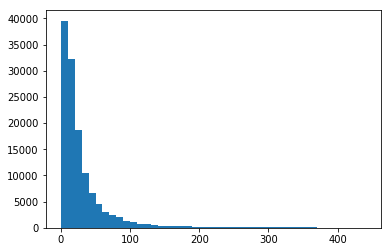

In [12]:
# analyze the comments length in x_train_sequences to decide on a max comment length
comments_lengths = [len(comment) for comment in x_train_sequences]
plt.hist(comments_lengths, bins=np.arange(0, 450, 10))
plt.show()

Looking at the the histogram above reveals that selecting a comment length of 100 should be a safe bet, 
since it covers most of the comments.

In [33]:
max_len = 100

# pad the training, validation, and test sets to have a maximum length of 100
x_train_sequences_padded = pad_sequences(x_train_sequences, maxlen=max_len)
x_validation_sequences_padded = pad_sequences(x_validation_sequences, maxlen=max_len)
x_test_sequences_padded = pad_sequences(x_test_sequences, maxlen=max_len)

### Evaluation Metric

The evaluation metric used in [kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge#evaluation) is the average of the individual AUROCs of each predicted column. Given that this is a multi-label, multi-class problem with class imbalance, this metric makes sense too. So, we'll use the same metric during model training and evalution.

Note: The AUROC score indicates the probability that a uniformly drawn postive random sample is ranked higher than a uniformly drawn negative random sample. This score is agnostic of the threshold used for classification.

In [14]:
class AUROC(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.x, self.y = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        # Calculate roc_auc_score. For multi-label, this function averages over the labels
        score = roc_auc_score(self.y, y_pred)
        print("val AUROC: %.6f" % (score))

### Model 1 (Baseline) - NN Using Count Vectors as Features

In [15]:
def create_count_vector_nn_model():
    model = Sequential()
    # first and only hidden layer with 128 units
    model.add(Dense(128, activation='relu', input_shape=(max_features,)))

    # since we are classifying each label separately, we use a sigmoid function for the output layer and 
    # binary_crossentropy as the loss function
    model.add(Dense(6, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_count_vector_nn = create_count_vector_nn_model()

# add early stopping which checks validation loss to avoid overfitting. 
# if the validation loss does not decrease by more than 0.0001 for more than 2 epochs, training stops.
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)

auroc = AUROC(validation_data=(x_validation, y_validation))

hist_count_vector_nn = model_count_vector_nn.fit(x_train, y_train, batch_size=500, epochs=10, 
                                                 validation_data=(x_validation, y_validation), 
                                                 callbacks=[early_stopping, auroc])

# save model in case it's needed later
model_count_vector_nn.save('models/history/count_vector_nn.h5')

# save model history in case it's needed later
with open('models/history/count_vector_nn_hist','wb') as f:
    pkl.dump(hist_count_vector_nn.history, f)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 276s 2ms/step - loss: 0.1651 - acc: 0.9681 - val_loss: 0.0878 - val_acc: 0.9759
val AUROC: 0.894829
Epoch 2/10
127656/127656 [==============================] - 232s 2ms/step - loss: 0.0690 - acc: 0.9794 - val_loss: 0.0744 - val_acc: 0.9784
val AUROC: 0.932605
Epoch 3/10
127656/127656 [==============================] - 208s 2ms/step - loss: 0.0530 - acc: 0.9832 - val_loss: 0.0709 - val_acc: 0.9791
val AUROC: 0.943739
Epoch 4/10
127656/127656 [==============================] - 222s 2ms/step - loss: 0.0440 - acc: 0.9857 - val_loss: 0.0701 - val_acc: 0.9796
val AUROC: 0.949563
Epoch 5/10
127656/127656 [==============================] - 201s 2ms/step - loss: 0.0376 - acc: 0.9879 - val_loss: 0.0726 - val_acc: 0.9798
val AUROC: 0.950013
Epoch 6/10
127656/127656 [==============================] - 193s 2ms/step - loss: 0.0328 - acc: 0.9896 - val_loss: 0.0738 - val_acc: 0.9798
val AUROC

Analyzing the validation loss and training loss logged by the model seems to indicate that there is no overfitting.

This model seems to be providing a good result for an intial attempt.

### Model 2 - NN Using Embedding

In [16]:
def create_embedding_nn_model():
    embedding_size = 16
    model_embedding_nn = Sequential()

    # Embedding layer to learn word embeddings. Embedding size chosen is 8
    model_embedding_nn.add(Embedding(max_features, embedding_size, input_length=max_len))

    # Flatten the output of the embedding layer so that it can be given as an input to a hidden layer
    model_embedding_nn.add(Flatten())

    # Single hidden layer with 64 hidden units
    model_embedding_nn.add(Dense(64, activation='relu'))
    model_embedding_nn.add(Dense(6, activation='sigmoid'))
    model_embedding_nn.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model_embedding_nn

model_embedding_nn = create_embedding_nn_model()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)
auroc = AUROC(validation_data=(x_validation_sequences_padded, y_validation))

# Fit model using early stopping
hist_embedding_nn = model_embedding_nn.fit(x_train_sequences_padded, y_train, batch_size=500, epochs=10, 
                                           validation_data=(x_validation_sequences_padded, y_validation), 
                                           callbacks=[early_stopping, auroc])

model_embedding_nn.save('models/embedding_nn.h5')

with open('models/history/embedding_nn_hist','wb') as f:
    pkl.dump(hist_embedding_nn.history, f)


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 21s 163us/step - loss: 0.1324 - val_loss: 0.0694
val AUROC: 0.956141
Epoch 2/10
127656/127656 [==============================] - 12s 97us/step - loss: 0.0583 - val_loss: 0.0606
val AUROC: 0.962127
Epoch 3/10
127656/127656 [==============================] - 13s 99us/step - loss: 0.0503 - val_loss: 0.0599
val AUROC: 0.962542
Epoch 4/10
127656/127656 [==============================] - 13s 105us/step - loss: 0.0459 - val_loss: 0.0598
val AUROC: 0.961091
Epoch 5/10
127656/127656 [==============================] - 13s 103us/step - loss: 0.0423 - val_loss: 0.0613
val AUROC: 0.959191
Epoch 00005: early stopping


This model too has a similar performance as that of the baseline model. However, this has a better AUROC and validation loss.

### Model 3 - NN Using a Pre-trained Embedding

The pre-trained model selected is GloVe. The model pre-trained on Twitter data is selected in the hopes that it reflects online user behaviour and generalizes well for our use-case.

In [36]:
# the selected GloVe model is the one with dimension = 100
transfer_embedding_size = 100

# create glove embeddings of our vocabulary
def create_embedding_matrix():
    glove_embeddings_index = dict()
    
    # create the glove embeddings index
    with open('data/glove.twitter.27B.100d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove_embeddings_index[word] = coefs

    # glove embeddings of our vocabulary
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, transfer_embedding_size))

    # words in our vocabulary that do not have a corresponding glove embedding
    words_with_no_embedding = []

    for word, i in tokenizer.word_index.items():
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        elif i < 10000:
            words_with_no_embedding.append(word)
        
    print (len(words_with_no_embedding))
    print (words_with_no_embedding)
    
    # save the embedding_matrix for later use
    with open("data/glove_embedding_matrix.pickle", "wb") as f:
        pkl.dump(embedding_matrix, f)
        
    return embedding_matrix
        

def load_embedding_matrix():
    embedding_matrix = None
    with open("data/glove_embedding_matrix.pickle", "rb") as f:
        embedding_matrix = pkl.load(f)
    return embedding_matrix


def create_glove_nn_model():
    model_glove_nn = Sequential()

    # embedding_matrix = create_embedding_matrix()
    embedding_matrix = load_embedding_matrix()
    
    # Embedding layer with weights initialized from glove_embedding_matrix.
    # The weights of the embedding layer will be adjusted during training, since trainable is not set to False.
    # By trial and error, it was found that training the embedding layer yielded better results.
    model_glove_nn.add(Embedding(len(tokenizer.word_index)+1, transfer_embedding_size, input_length=max_len, 
                             weights=[embedding_matrix]))
    # flatten the word embeddings, so that it can be fed to a Dense layer.
    model_glove_nn.add(Flatten())
    model_glove_nn.add(Dense(256, activation='relu'))
    model_glove_nn.add(Dense(6, activation='sigmoid'))

    model_glove_nn.compile(loss='binary_crossentropy', optimizer='adam')
    return model_glove_nn


model_glove_nn = create_glove_nn_model()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)
auroc = AUROC(validation_data=(x_validation_sequences_padded, y_validation))

hist_glove_nn = model_glove_nn.fit(x_train_sequences_padded, y_train, batch_size=500, epochs=10,
                                  validation_data=(x_validation_sequences_padded, y_validation),
                                  callbacks=[early_stopping, auroc])

model_glove_nn.save('models/glove_nn.h5')
with open('models/history/glove_nn_hist', 'wb') as f:
    pkl.dump(hist_glove_nn.history, f)

400
["don't", "i'm", "it's", "i've", "you're", "doesn't", "that's", "i'll", "didn't", "can't", "isn't", "i'd", "there's", 'contribs', "wikipedia's", "you've", "wasn't", "won't", "he's", 'wikiproject', 'npov', "haven't", "article's", "what's", "wouldn't", "aren't", "shouldn't", "let's", "they're", "you'll", 'infobox', "we're", "''''''", "you'd", 'barnstar', 'unsourced', 'wikipedians', "couldn't", 'fucksex', 'sockpuppet', 'disambiguation', 'fffa', "here's", 'buttsecks', "subject's", 'arbcom', 'verifiability', 'userpage', "people's", 'philippineslong', '—preceding', 'mothjer', "hasn't", 'talkpage', 'offfuck', 'gfdl', 'oldid', 'sexsex', 'deneid', "we'll", "'fuck", 'pagedelete', 'yourselfgo', 'notrhbysouthbanof', "'image'", "weren't", "'''", "we've", 'sockpuppetry', 'cellpadding', "she's", 'bunksteve', 'marcolfuck', 'unconstructive', 'ytmnd', 'deletions', "who's", 'securityfuck', "user's", 'mainpagebg', 'adminship', 'youbollocks', "hadn't", "they've", 'don’t', "''''", '\u200e', 'conformance

There are 400 words in our vocabulary that do not have a corresponding embedding in glove. Most of them seems to be ones that can be safely ignored. 

The performance of this model is better than that of the model with a learned embedding. However, an embedding layer initialized with glove vectors but not trainable had yielded worse results. (Those results are not shown in this notebook). 

### Model 4 - RNN Using Embedding

Since the glove model yielded better results, trying an RNN with LSTM cell that uses the same trainable embedding. Keeping track of the words in the comments in memory might prove to be useful to understand the comment better. This is the intuition behind using an RNN. Also, since words early on in the comment could be more useful, we are using an LSTM.

In [62]:
def create_rnn_model():
    embedding_size = 16
    model_embedding_rn = Sequential()
    
    # load GloVe embedding matrix used in previous model
    embedding_matrix = load_embedding_matrix()
    
    # trainable embedding layer initialized using the embedding matrix from above
    model_embedding_rn.add(Embedding(len(tokenizer.word_index)+1, transfer_embedding_size, input_length=max_len, 
                             weights=[embedding_matrix]))

    # LSTM layer with dropout - since LSTMs are prone to overfitting
    model_embedding_rn.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
    model_embedding_rn.add(Dense(32, activation='relu'))
    # more dropout regularization
    model_embedding_rn.add(Dropout(0.1))
    model_embedding_rn.add(Dense(6, activation='sigmoid'))
    model_embedding_rn.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model_embedding_rn


model_embedding_rn = create_rnn_model()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)
auroc = AUROC(validation_data=(x_validation_sequences_padded, y_validation))

hist_embedding_rn = model_embedding_rn.fit(x_train_sequences_padded, y_train, batch_size=500, epochs=20, 
                                           validation_data=(x_validation_sequences_padded, y_validation), 
                                           callbacks=[early_stopping, auroc])

model_embedding_rn.save('models/embedding_rn.h5')

with open('models/history/embedding_rn_hist','wb') as f:
    pkl.dump(hist_embedding_rn.history, f)

Train on 114890 samples, validate on 12766 samples
Epoch 1/20
114890/114890 [==============================] - 1055s 9ms/step - loss: 0.1318 - val_loss: 0.0546
val AUROC: 0.970560
Epoch 2/20
114890/114890 [==============================] - 1117s 10ms/step - loss: 0.0552 - val_loss: 0.0494
val AUROC: 0.974625
Epoch 3/20
114890/114890 [==============================] - 1160s 10ms/step - loss: 0.0489 - val_loss: 0.0480
val AUROC: 0.977281
Epoch 4/20
114890/114890 [==============================] - 1231s 11ms/step - loss: 0.0453 - val_loss: 0.0477
val AUROC: 0.978690
Epoch 5/20
114890/114890 [==============================] - 1325s 12ms/step - loss: 0.0426 - val_loss: 0.0477
val AUROC: 0.979430
Epoch 6/20
114890/114890 [==============================] - 1282s 11ms/step - loss: 0.0401 - val_loss: 0.0496
val AUROC: 0.979345
Epoch 00006: early stopping


Based on the validation loss and the validation auroc score, this seems to be the better model. However, the training time for the model to converge is higher compared to the other models.

In [80]:
# Load the best-performing model
from keras.models import load_model
def load_saved_rnn_model():
    return load_model('models/embedding_rn.h5')

### Prediction on Test Data using the Selected Model

Since the RNN has the best performance in terms of validation loss and validation auroc score, we select that.

In [81]:
model = load_saved_rnn_model()

# predict on held-out test data
y_pred = model.predict(x_test_sequences_padded)

### Test Result Analysis
Analyze AUROC scores and confusion matrix to get a better idea of the results, since there is class imbalance

In [82]:
# analyze mean auroc score and auroc score for each label
auroc_score = roc_auc_score(y_test, y_pred)
print ('Mean AUROC Score:', auroc_score)

for i in range(0, 6):
    print (dependent_vars[i], ':', roc_auc_score(y_test[:, i], y_pred[:, i]))

Mean AUROC Score: 0.9800690380177524
toxic : 0.9734392480335463
severe_toxic : 0.9878210443845843
obscene : 0.9886028243622969
threat : 0.9727391591260901
insult : 0.9806614957212978
identity_hate : 0.977150456478699


The mean AUROC score of the validation data has translated well to the test data. The model seems to predicting 'obscene' labels well. On the other hand, 'threat' and 'identity_hate' labels seem to have taken a hit. This could be due to the label imbalance.

In [83]:
# make absolute predictions using a threshold of 0.5
threshold = 0.5
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

In [88]:
# check confusion matrix for each label
for i in range(0, 6):
    print (dependent_vars[i])
    print ('TN,      FP,    FN,    TP')
    print (confusion_matrix(y_test[:, i], y_pred[:, i]).ravel())
    print ('\n')

toxic
TN,      FP,    FN,    TP
[28526   272   944  2173]


severe_toxic
TN,      FP,    FN,    TP
[31495    60   285    75]


obscene
TN,      FP,    FN,    TP
[29956   252   340  1367]


threat
TN,      FP,    FN,    TP
[31819     4    89     3]


insult
TN,      FP,    FN,    TP
[29975   333   534  1073]


identity_hate
TN,      FP,    FN,    TP
[31612    34   204    65]




The analysis above seems to be right. The model especially seems to be struggling with the threat label. It is reluctant to label a comment as a threat - only 3 TPs out of ~32K data points when in fact there were 92 true labels.

### Analyze Misclassified Threat Comments

In [97]:
pd.set_option('display.max_colwidth', -1)
print ("Comments that are TP threats: ")
print (test['comment_text'].loc[np.logical_and(y_pred[:, 3] == 1, y_test[:, 3] == 1)])

print ("\n\n\nComments that are FN threats: ")
print (test['comment_text'].loc[np.logical_and(y_pred[:, 3] == 0, y_test[:, 3] == 1)])

Comments that are TP threats: 
120401    hope die hope die                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

As seen from the examples above, the model seems to need strong evidence without too much dilution of features like 'kill' and 'die' by other words, to label a comment as a threat.

### Improvements

##### Code Improvements:
1. Use scikit-learn Pipeline to modularize the code more.
2. Use GridSearchCV for better tuning of hyperparameters

##### Model Improvements:
1. Set the 'class_weights' parameter in the fit function to inverse class frequencies as mentioned [here](https://keras.io/models/sequential/#fit).
2. Try an ensemble of models with each model focusing on one label. Each model can then try to optimize an f1_score for the label it focuses on.
3. Pseudo-labeling could be tried after the model reaches a satisfactory performance on labels that are causing issues.
4. Use more efficient preprocessing:
   a) Remove spelling mistakes by using edit distances. A GloVe or similar model could be used to correct these mistakes.
   b) Try a bigger vocabulary size
   c) Lemmatizing
5. Choose better thresholds for the different labels for prediction.